<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/main/tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tomato Disease Detection Model using Deep Learning**

# **1. Introduction**

 ## Overview.

Tomatoes are one of the most important crops in Kenya, both economically and nutritionally. They are a staple in the diet of many Kenyans and a significant source of income for smallholder farmers. However, tomato production in Kenya faces numerous challenges, among which diseases are the most important. Tomato plants are susceptible to various diseases caused by fungi, bacteria, viruses, and pests. These diseases can lead to substantial yield losses, reduced produce quality, and increased production costs due to the need for pesticides and other control measures.

In Kenya, the impact of tomato diseases is exacerbated by several factors:

1. Limited Access to Knowledge and Resources: Many smallholder farmers lack access to information on disease identification and management practices.
2. Extension services are often inadequate, leaving farmers without the necessary support to effectively combat tomato diseases.

3. Climate and Environmental Conditions: Kenya's diverse climate and environmental conditions can create favorable conditions for the spread and persistence of various tomato diseases. Changes in weather patterns due to climate change further complicate disease management.

4. Economic Constraints: The financial constraints of smallholder farmers limit their ability to invest in disease management solutions such as resistant seed varieties, appropriate chemicals, and modern farming techniques.

5. Inadequate Diagnostic Tools: Traditional methods of disease diagnosis are often slow, inaccurate, and labor-intensive. There is a need for rapid, accurate, and cost-effective diagnostic tools that can be easily used by farmers in the field.


The consequences of unchecked tomato diseases are severe. Yield losses can range from 20% to 100%, depending on the type and severity of the disease. This not only affects the income of farmers but also threatens food security and nutrition for millions of Kenyans. Addressing tomato diseases effectively is therefore crucial for enhancing agricultural productivity, improving the livelihoods of smallholder farmers, and ensuring food security in Kenya.


## Business Problem.

Agriculture is a cornerstone of Kenya's economy, with a majority of the population relying on it for their livelihood. However, plant diseases pose a significant threat to crop yields, leading to economic hardships for farmers and contributing to food insecurity. Traditional methods of disease detection are often slow, costly, and require expert knowledge. An automated plant disease detection system using image data can empower Kenyan farmers to quickly and accurately identify diseases, take timely actions, and improve crop productivity.

The goal of this project is to develop an automated system for detecting plant diseases in Kenya using image recognition technology. This system will enable farmers to identify various plant diseases from images of leaves, providing accurate and timely diagnostic information to help mitigate crop losses.

## Data Source.

Our dataset was downloaded from a Kaggle repository authored by Plant Village.

PlantVillage is an organization hosted by Penn State University, is a research initiative focused on enhancing agricultural resilience and sustainability, particularly in the context of climate change. The platform employs advanced technologies such as artificial intelligence and data analytics to address various agricultural challenges including plant disease, which will be the focus of this project.
For this project we shall focus on Tomato Leaves.

The link to the repository is here: https://www.kaggle.com/datasets/emmarex/plantdisease?select=PlantVillage

Dataset Author Website: https://plantvillage.psu.edu/

## Objectives.

1. Dataset Development: Collect and preprocess a diverse dataset of plant leaf images from Kenyan farms, labeled with various disease types.
2. Model Development: Build and train a Deep Learning model to classify images of plant leaves into healthy or diseased categories.
3. Model Evaluation: Evaluate the model’s performance using accuracy, precision, recall, and F1-score metrics.
4. Deployment: Develop a user-friendly mobile application that allows Kenyan farmers to upload images and receive disease diagnosis and treatment recommendations.
5. Impact Assessment: Evaluate the system’s impact on crop yield and farmer decision-making through pilot studies and feedback from Kenyan farmers.


## Metrics of Success

1. Model Accuracy: Achieve a classification accuracy of over 90%.
2. Precision and Recall: Achieve precision and recall scores of over 85% for each disease category.


# **2. Loading of Libraries and Data.**

##  Importing Relevant Libraries

In [2]:
# from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers
from keras.applications import VGG19
from keras import models
from keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
# !pip install EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB0
!pip install efficientnet
import efficientnet.tfkeras as efn
# loading MobileNet V2 Model
from tensorflow.keras.applications import MobileNetV2
#import earlystopping
from tensorflow.keras.callbacks import EarlyStopping #earlystopping
from keras.applications import VGG19
#Recording History in json
import json
!pip install wandb
import wandb
from wandb.integration.keras import WandbCallback

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your folder
#folder_path = '/Users/andrewbaraka/Documents/Tomato'

# Set the path to the dataset directory
# folder_path = r'C:\Users\Lisa\Desktop\PlantDisease\Tomato'

Mounted at /content/drive


In [3]:
folder_path='/content/drive/MyDrive/PlantVillage'

## Loading our dataset.

In [4]:
#loading the dataset
data= tf.keras.utils.image_dataset_from_directory(folder_path, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(224, 224), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16031 files belonging to 10 classes.


In [5]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break


The length of our data is 501
Image Batch Shape (32, 224, 224, 3)
Label Batch Shape (32, 10)


## Visualizing some of our images

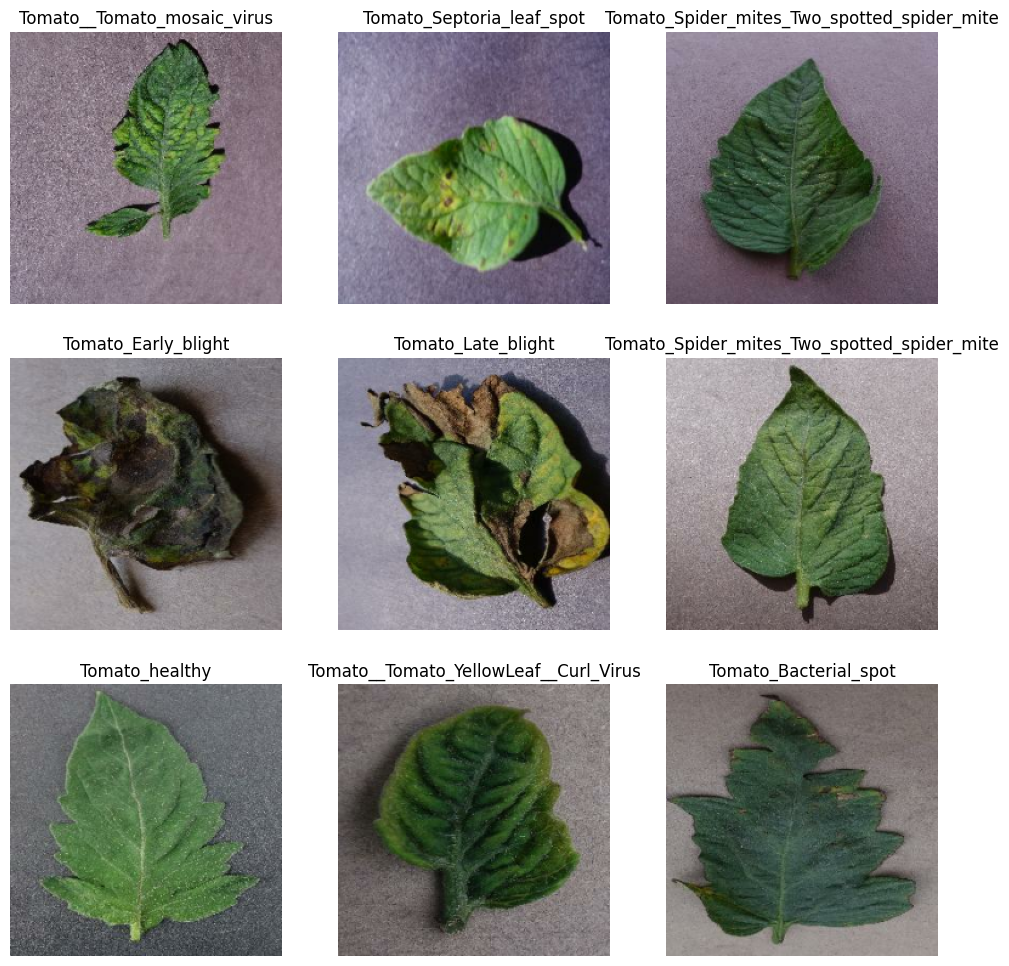

In [6]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


# **3. Data Cleaning and Preperation**

## Cleaning the class names

In [7]:
#Checking our class names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:

# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

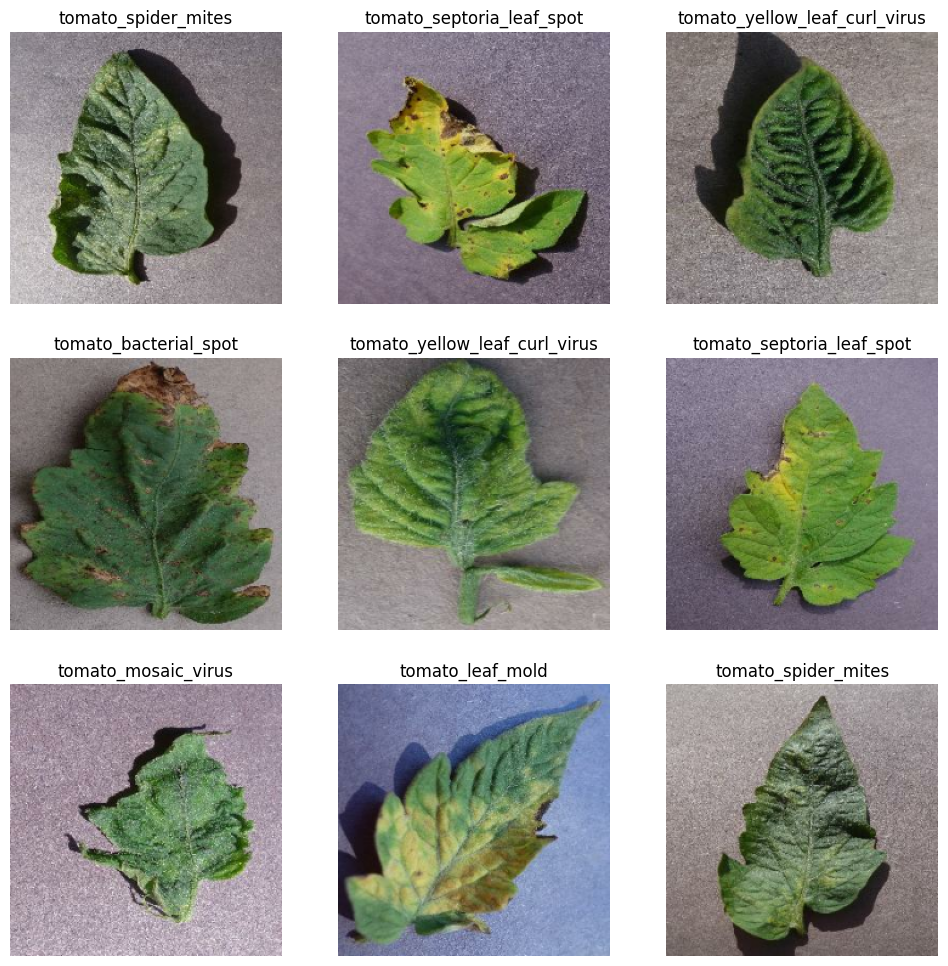

In [9]:
preview_data(data, class_names)

## Checking for Corrupt images

In [ ]:
def check_corrupt_images(folder_path):
    corrupt_images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(folder_path)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [ ]:
# Removing Corrupt images
for img_path in corrupt_images:
    try:
      os.remove(img_path)
      print(f"Corrupt image removed:{img_path}")
    except OSError:
      pass

## Class Distribution

In [10]:
# # A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


Sorted class distribution (ascending): {'tomato_mosaic_virus': 373, 'tomato_leaf_mold': 952, 'tomato_early_blight': 1000, 'tomato_target_spot': 1404, 'tomato_healthy': 1601, 'tomato_spider_mites': 1676, 'tomato_septoria_leaf_spot': 1771, 'tomato_late_blight': 1919, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208}


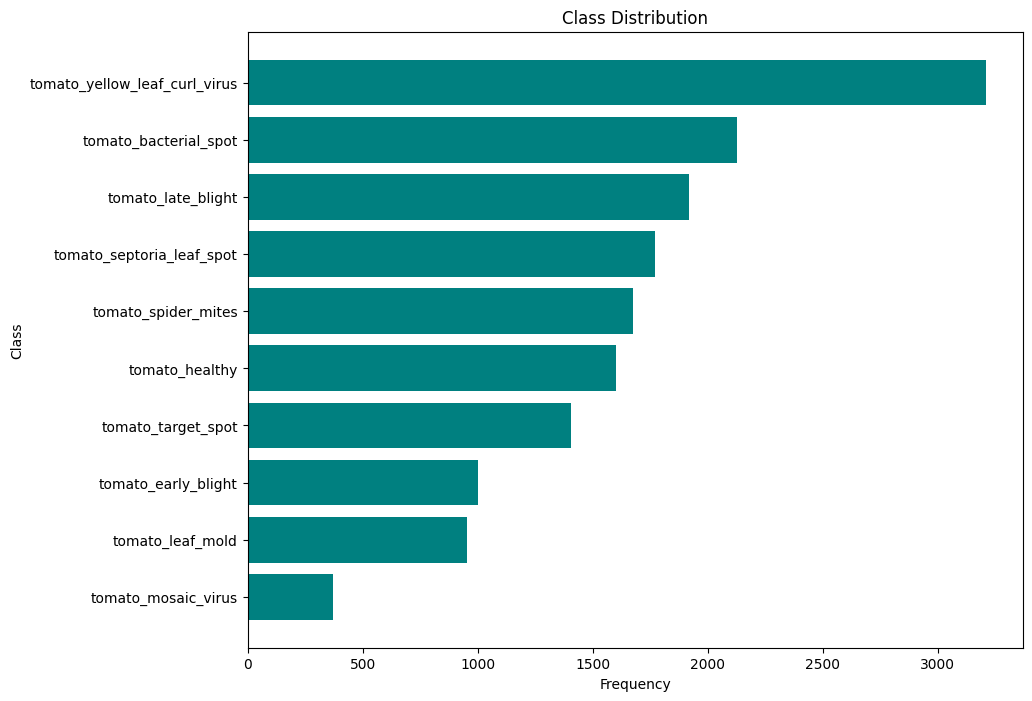

In [11]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

# **4. Data Preprocessing**

### Splitting our data set to Train, validation and Test Datasets.

In [5]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectivly
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size).skip(val_size)

  return train_set, val_set, test_set


In [6]:
# Printing the length of our train, validation and test data
train_set, val_set, test_set = split_data(data)
print(len(train_set))
print(len(val_set))
print(len(test_set))

400
50
51


In [7]:
print("Train data element spec:", train_set.element_spec)
print("Validation data element spec:", val_set.element_spec)

Train data element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation data element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


## Caching our data

In [8]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Resizing, Rescaling and Augmentation

In [9]:
img_size = 256

# Creating an instance to Resize our data
resize_and_rescale = tf.keras.Sequential([
               layers.Resizing(img_size,img_size),
               layers.Rescaling(1.0/255)
])

# Creating a data augmentation instance for our data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)

])

In [10]:
# Apply data augmentation to the training set only
def augment(image, label):
    image = data_augmentation(image)
    return image, label

train_set = train_set.map(augment)

# **5. Modeling**

- We will begin by defining the functions that can be reused throught the modelling phase and defining some global variables

In [11]:
# function to plot training history

def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


In [12]:
# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [13]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_set):

    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

    # Print out the test loss and accuracy
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

    return test_loss, test_accuracy



In [14]:
import numpy as np

def generate_predictions(model, test_set, batch_size=32, sample_size=10):
    """
    Generate predictions for the test set and display a sample of predictions.

    Parameters:
    - model: The trained model to use for predictions.
    - test_set: The test dataset to predict on.
    - batch_size: The batch size used in the test set.
    - sample_size: The number of sample predictions to display.

    Returns:
    - true_labels: List of true labels from the test set.
    - predicted_labels: List of predicted labels from the model.
    """
    true_labels = []
    predicted_labels = []

    for images, labels in test_set:
        preds = model.predict(images, batch_size=batch_size)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        predicted_labels.extend(np.argmax(preds, axis=1))

    # Display a sample of predictions
    for i in range(sample_size):
        print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")

    return true_labels, predicted_labels



### Model 1: Convolutional Neural Network
- We have selected CNN as our baselline model since it is not computationally expensive and has the ability to capture spatial hierarchies in imaes through convolutional layers.

In [ ]:
#Sequential model

model_c = models.Sequential([
    resize_and_rescale, #normalizes pixel values and ensuring consistent input size.
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32,256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25), # reduces overfitting through regularization
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])


In [ ]:
model_c.build(input_shape = (32,256,256,3))

In [ ]:
model_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 111, 111, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                 

- The CNN model consists of 5 convolutional blocks each followed by a maxpooling and a dropout  layer for downsampling and regularization. The model's depth enables hierarchical feature extraction, ending with a flatten layer and two dense layers for classification.

In [ ]:
# compiling the model with the Adam optimizer , cateegorical crossentropy loss and accuracy metric
model_c.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)
# training the model on the training set
history_c = model_c.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
400/400 [==============================] - 215s 465ms/step - loss: 1.7034 - accuracy: 0.3921 - val_loss: 1.6377 - val_accuracy: 0.3988
Epoch 2/50
400/400 [==============================] - 156s 390ms/step - loss: 1.1763 - accuracy: 0.5854 - val_loss: 1.1201 - val_accuracy: 0.5900
Epoch 3/50
400/400 [==============================] - 154s 386ms/step - loss: 0.7985 - accuracy: 0.7169 - val_loss: 0.9445 - val_accuracy: 0.6581
Epoch 4/50
400/400 [==============================] - 154s 385ms/step - loss: 0.5989 - accuracy: 0.7860 - val_loss: 0.9735 - val_accuracy: 0.6862
Epoch 5/50
400/400 [==============================] - 154s 385ms/step - loss: 0.4812 - accuracy: 0.8317 - val_loss: 0.6870 - val_accuracy: 0.7756
Epoch 6/50
400/400 [==============================] - 154s 385ms/step - loss: 0.4202 - accuracy: 0.8549 - val_loss: 0.5583 - val_accuracy: 0.8037
Epoch 7/50
400/400 [==============================] - 155s 387ms/step - loss: 0.3696 - accuracy: 0.8701 - val_loss: 0.3599 -

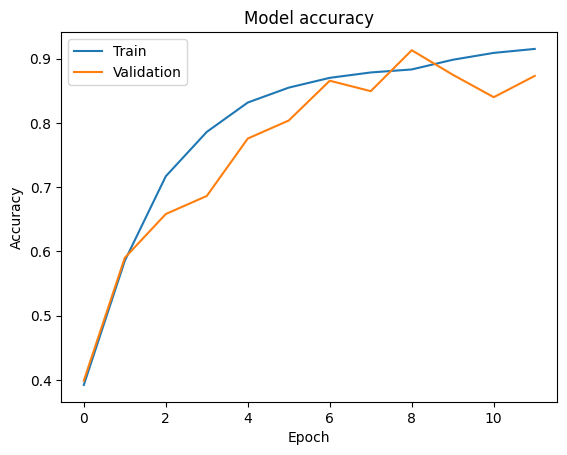

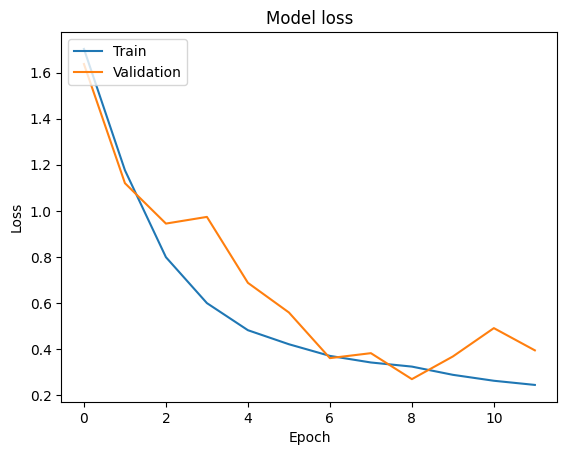

In [36]:
# plot_training_history(history_c)
# Load history from the JSON file
# with open('history_cnn.json', 'r') as f:
# #     history_c = json.load(f)
# # plot_training_history(history_c)
# import matplotlib.pyplot as plt
# import json

# def plot_training_history(history):
#   # Check if the history is a dictionary (loaded from JSON)
#   if isinstance(history, dict):
#     # Extract metrics from the dictionary
#     accuracy = history.get('accuracy', [])
#     val_accuracy = history.get('val_accuracy', [])
#     loss = history.get('loss', [])
#     val_loss = history.get('val_loss', [])
#   else:
#     # Use the history object directly
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#   # Plot training & validation accuracy values
#   plt.plot(accuracy)
#   plt.plot(val_accuracy)
#   plt.title('Model accuracy')
#   plt.ylabel('Accuracy')
#   plt.xlabel('Epoch')
#   plt.legend(['Train', 'Validation'], loc='upper left')
#   plt.show()
#   # plot training and validation loss values
#   # loss = history.history['loss']
#   # val_loss = history.history['val_loss']
#   plt.plot(loss)
#   plt.plot(val_loss)
#   plt.title('Model loss')
#   plt.ylabel('Loss')
#   plt.xlabel('Epoch')
#   plt.legend(['Train', 'Validation'], loc='upper left')
# Load history from the JSON file
with open('history_cnn.json', 'r') as f:
    history_c = json.load(f)

plot_training_history(history_c)

#### **Observations**
- The training accuracy increases steadily as the number of epochs increase meaning the modle is learning well to the training data.
- The validation accuracy increases initially as the number of epochs increase however, the there is some fluctuations indicatiting a little bit of overfitting meaning the model fits training data well than validation data.
- The training loss decreases as the number of epochs increase.
- The validation loss shows significant fluctuations as the number of epochs decrease indiicating inconsistent performance on the vakidation set

In [ ]:
#evaluating the model on test data
test_loss, test_accuracy = evaluate_model(model_c, test_set)

51/51 [==============================] - 4s 80ms/step - loss: 0.2589 - accuracy: 0.9179
Test Loss: 0.2589
Test Accuracy: 0.9179


In [ ]:
#generating predictions
true_labels, predicted_labels = generate_predictions(model_c, test_set, batch_size=32, sample_size=10)

1/1 [==============================] - 0s 100ms/step
True label: 2, Predicted label: 2
True label: 4, Predicted label: 4
True label: 0, Predicted label: 0
True label: 6, Predicted label: 5
True label: 7, Predicted label: 7
True label: 0, Predicted label: 0
True label: 4, Predicted label: 4
True label: 2, Predicted label: 2
True label: 4, Predicted label: 4
True label: 6, Predicted label: 6


- Out of 10 samples, the model made 8 correct predictions and 2 incorrect predictions.
- The model shows a difficulty distinguishing between classes 6 and 5. This suggests that the features distinguishing these two classes may be similar, causing confusion during prediction.
- While the model performs well overall, it struggles to differentiate between certain classes.

In [ ]:
# save model in keras

model_c.save('cnnbase_model.keras')


In [ ]:
history_c.history

{'loss': [1.7034491300582886,
  1.1762672662734985,
  0.7984511852264404,
  0.5989460349082947,
  0.48124900460243225,
  0.4202486276626587,
  0.3695800304412842,
  0.34099796414375305,
  0.3230813443660736,
  0.28735676407814026,
  0.26155513525009155,
  0.24347175657749176],
 'accuracy': [0.39206188917160034,
  0.585358202457428,
  0.7169309854507446,
  0.7859988808631897,
  0.831705629825592,
  0.8549105525016785,
  0.8701460957527161,
  0.8785061240196228,
  0.8831940293312073,
  0.8982732892036438,
  0.9089772701263428,
  0.9151496291160583],
 'val_loss': [1.6377111673355103,
  1.1200639009475708,
  0.9445351958274841,
  0.9735368490219116,
  0.6870337128639221,
  0.5582649111747742,
  0.35991257429122925,
  0.3814587891101837,
  0.2685970366001129,
  0.36713218688964844,
  0.4902646541595459,
  0.3937084674835205],
 'val_accuracy': [0.3987500071525574,
  0.5899999737739563,
  0.6581249833106995,
  0.6862499713897705,
  0.7756249904632568,
  0.8037499785423279,
  0.865625023841857

In [ ]:

with open('history_cnn.json','w') as f:
  json.dump(history_c.history,f)

### Model 2: VGG19 pretrained network.
- Onto our next model we will use VGG19 which is oftenly used a pretrained network  model on larger datasets. This  will allow us to extract features effectively from our images and improve on our baseline model.

In [21]:
#initialize the base
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))
# Define Model Architecture
model_vgg19 = models.Sequential()
model_vgg19.add(cnn_base)
model_vgg19.add(layers.Flatten())
model_vgg19.add(layers.Dense(64, activation='relu'))
model_vgg19.add(layers.Dense(128, activation='relu'))
model_vgg19.add(layers.Dense(256, activation='relu'))
model_vgg19.add(layers.Dense(128, activation='relu'))
model_vgg19.add(layers.Dense(10, activation='softmax'))

cnn_base.trainable=False #freeze the base model to prevent the pretrained weights from being updated during training

for layer in model_vgg19.layers:
  print(layer.name, layer.trainable)

# check how many trainable weights are in the model
print(len(model_vgg19.trainable_weights))

model_vgg19.summary()

80134624/80134624 [==============================] - 0s 0us/step
vgg19 False
flatten True
dense True
dense_1 True
dense_2 True
dense_3 True
dense_4 True
10
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (

In [24]:
#compiling the model
model_vgg19.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

history_vgg19= model_vgg19.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
400/400 [==============================] - 380s 880ms/step - loss: 0.9974 - accuracy: 0.6783 - val_loss: 0.7600 - val_accuracy: 0.7481
Epoch 2/50
400/400 [==============================] - 329s 823ms/step - loss: 0.5464 - accuracy: 0.8169 - val_loss: 0.4726 - val_accuracy: 0.8475
Epoch 3/50
400/400 [==============================] - 331s 827ms/step - loss: 0.4466 - accuracy: 0.8500 - val_loss: 0.4113 - val_accuracy: 0.8675
Epoch 4/50
400/400 [==============================] - 331s 827ms/step - loss: 0.3802 - accuracy: 0.8720 - val_loss: 0.3557 - val_accuracy: 0.8788
Epoch 5/50
400/400 [==============================] - 329s 822ms/step - loss: 0.3671 - accuracy: 0.8769 - val_loss: 0.3668 - val_accuracy: 0.8938
Epoch 6/50
400/400 [==============================] - 326s 816ms/step - loss: 0.3335 - accuracy: 0.8866 - val_loss: 0.3459 - val_accuracy: 0.8838
Epoch 7/50
400/400 [==============================] - 331s 826ms/step - loss: 0.3025 - accuracy: 0.8966 - val_loss: 0.3321 -

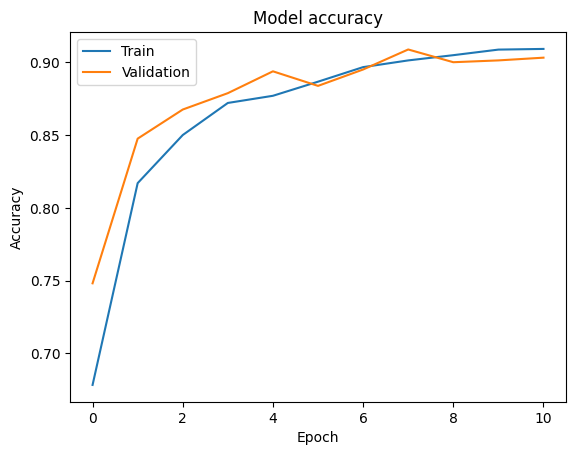

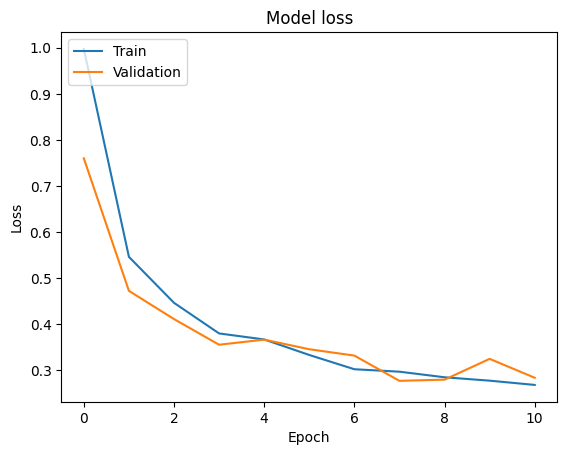

In [25]:

plot_training_history(history_vgg19)

#### Observations
- The training accuracy increases steadily as the number of epochs increase meaning the modle is learning well to the training data.
- The validation accuracy increases initially as the number of epochs increase however, the there is still some fluctuations indicatiting a little bit of overfitting.
- The training loss decreases as the number of epochs increase.
- The validation loss shows a few fluctuations as the number of epochs decrease indicating inconsistent performance on the vakidation set.
- The Overall perfomance of the model is etterr than our CNN model since oyur validation sets have showwed improvement in the fluctuaions indicating the model is able to generalize better.

In [26]:
#evaluating the model on test data
test_loss, test_accuracy = evaluate_model(model_vgg19, test_set)

51/51 [==============================] - 62s 722ms/step - loss: 0.2130 - accuracy: 0.9246
Test Loss: 0.2130
Test Accuracy: 0.9246


In [27]:
#generating predictions
true_labels, predicted_labels = generate_predictions(model_vgg19, test_set, batch_size=32, sample_size=10)

1/1 [==============================] - 1s 718ms/step
True label: 4, Predicted label: 4
True label: 4, Predicted label: 4
True label: 4, Predicted label: 4
True label: 6, Predicted label: 6
True label: 7, Predicted label: 7
True label: 4, Predicted label: 4
True label: 5, Predicted label: 5
True label: 2, Predicted label: 2
True label: 9, Predicted label: 9
True label: 5, Predicted label: 5


- The loss of 0.2604 indicates how well the model’s predictions are matching the true labels. Lower loss values generally signify better model performance. The accuracy of 92.34% indicates that the model correctly predicted the labels for about 92.34% of the training samples

In [28]:
history_vgg19.history

{'loss': [0.9974234104156494,
  0.5463771224021912,
  0.4466173052787781,
  0.3802051544189453,
  0.36714163422584534,
  0.33347222208976746,
  0.302527517080307,
  0.29721322655677795,
  0.2850961983203888,
  0.2777496576309204,
  0.26851099729537964],
 'accuracy': [0.6783342361450195,
  0.8169388175010681,
  0.8499882817268372,
  0.8720212578773499,
  0.8769435286521912,
  0.8866317868232727,
  0.8966325521469116,
  0.9012422561645508,
  0.9048362970352173,
  0.9086647629737854,
  0.9091335535049438],
 'val_loss': [0.7600492835044861,
  0.4725649654865265,
  0.41134101152420044,
  0.3557203710079193,
  0.366769939661026,
  0.3459271192550659,
  0.33211031556129456,
  0.27736836671829224,
  0.27994439005851746,
  0.3250439167022705,
  0.28402194380760193],
 'val_accuracy': [0.7481250166893005,
  0.8475000262260437,
  0.8675000071525574,
  0.8787500262260437,
  0.893750011920929,
  0.8837500214576721,
  0.8949999809265137,
  0.9087499976158142,
  0.8999999761581421,
  0.901250004768371

In [29]:
# dumping the history to the json file
with open('history_vgg19.json','w') as f:
  json.dump(history_vgg19.history,f)

In [31]:
#saving model3 with keras

model_vgg19.save('model_vgg19.keras')



- The model correctly predicted 9 out of 10 labels in this sample. The only incorrect prediction was where the true label was 4, but the model predicted 6. This indicates that the model is performing well, with a high accuracy in this sample, but there is room for improvement, especially in distinguishing between classes that might be similar or have overlapping features.

## Model 3: EfficientNetB0

The EfficientNetB0 model, a convolutional neural network architecture, is employed for image classification.

The model is initialized with pre-trained weights from ImageNet, leveraging transfer learning for enhanced feature extraction.

The base model's layers are frozen to retain pre-trained knowledge, while custom layers are added for task-specific classification.

Early stopping is implemented to prevent overfitting and optimize training duration.

The model is compiled with the Adam optimizer, categorical crossentropy loss, and accuracy metric, tailored for multi-class classification.

Training is performed over a specified number of epochs, utilizing the training and validation datasets for model optimization.

In [15]:
# Loading the EfficientNetB0 model pre-trained on ImageNet, with the top layers removed

# Defining the EfficientNetB0 Base model
base_model = efn.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
    )

# Freezing the base model
base_model.trainable = False

# Defining the number of classes
num_classes = 10

# Custom layers on top of the base model
model_efn = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])


# Compile the model
model_efn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Building the model
model_efn.build(input_shape=(None, 224, 224, 3))

# Print model summary to verify parameter counts
model_efn.summary()

# Train the model
epochs = 50
history_efn = model_efn.fit(train_set,
                 epochs=epochs,
                 validation_data=val_set,
                 callbacks=[early_stopping]
                 )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 efficientnet-b0 (Functiona  (None, 8, 8, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)               

**Visualizing the perfomance of our model**

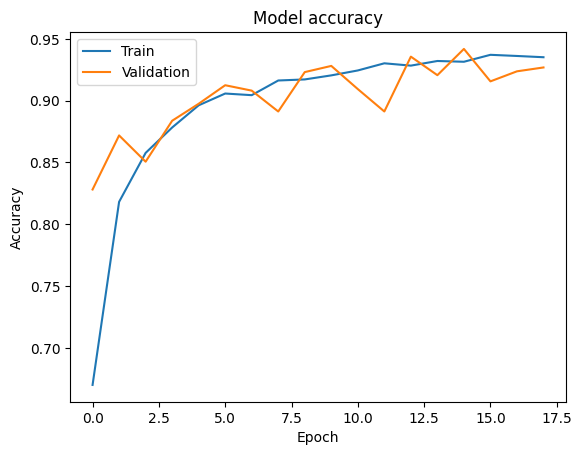

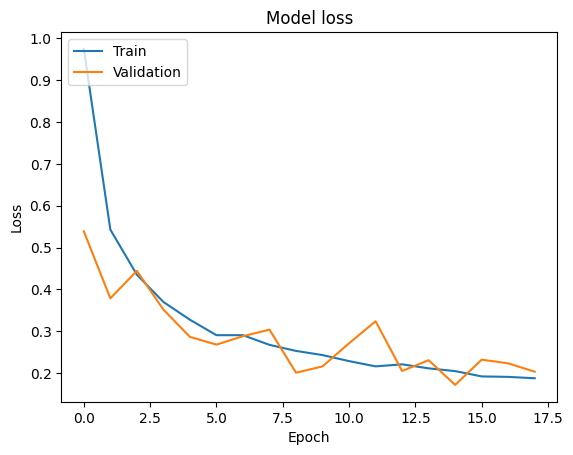

In [16]:

plot_training_history(history_efn)


**Recording the Model History in Json**

In [17]:
with open('history_efn.json','w') as f:
  json.dump(history_efn.history,f)

**Saving Our Model using Keras**

In [18]:
model_efn.save('efnb0.keras')

**Evaluating our model against the Test_set**

In [19]:
#Evaluating our model

test_loss, test_accuracy =evaluate_model(model_efn, test_set)


51/51 [==============================] - 43s 360ms/step - loss: 0.1317 - accuracy: 0.9559
Test Loss: 0.1317
Test Accuracy: 0.9559


**Gerenating Label Predictions for Our test_set**

In [20]:
#generating predictions
true_labels, predicted_labels = generate_predictions(model_efn, test_set, batch_size=32, sample_size=10)

1/1 [==============================] - 0s 394ms/step
True label: 0, Predicted label: 0
True label: 7, Predicted label: 7
True label: 9, Predicted label: 9
True label: 0, Predicted label: 0
True label: 0, Predicted label: 0
True label: 0, Predicted label: 0
True label: 4, Predicted label: 4
True label: 3, Predicted label: 3
True label: 5, Predicted label: 5
True label: 0, Predicted label: 0


### Observations


1.   The training accuracy steadily increases as the number of epochs increases, indicating effective learning from the training data.
2.   Validation accuracy shows a general upward trend, suggesting good generalization to unseen data. Minor fluctuations might indicate slight overfitting, but the overall trend is positive.
3.   Training loss consistently decreases, demonstrating the model's ability to minimize errors on the training set.
4.   Validation loss exhibits some fluctuations, possibly due to the limited size of the validation set or inherent complexity of the task. However, the overall trend shows a decrease, indicating progress in reducing prediction errors on unseen data.
5.   The model demonstrates strong performance, achieving a high accuracy on the test set of 95.28%. This suggests that the EfficientNetB0 architecture, combined with the chosen training strategy, is well-suited for this image classification task.
















## Model 4: MobileNet V2.

In [ ]:
# # Creating a split of our data into train, validation and 80% ,10% and 10% Respectively
# def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):

#   # Calculating the length of our dataset
#   data_size = len(data)
#   if shuffle:
#     data = data.shuffle(shuffle_size) #Shuffling our data
#   train_size = int(train_split* len(data))
#   val_size = int(val_split*len(data))

#   train_set = data.take(train_size)
#   val_set = data.skip(train_size).take(val_size)
#   test_set = data.skip(train_size + val_size)

#   return train_set, val_set, test_set

# # Define the get_subset function if it's not defined elsewhere
# def get_subset(dataset, fraction):
#   """
#   Returns a subset of the given dataset.

#   Args:
#     dataset: The dataset to extract a subset from.
#     fraction: The fraction of the dataset to return.

#   Returns:
#     A subset of the original dataset.
#   """
#   subset_size = int(len(dataset) * fraction)
#   return dataset.take(subset_size)

# # Data Subset
# train_subset = get_subset(train_set, 1/3)
# val_subset = get_subset(val_set, 1/3)
# test_subset = get_subset(test_set, 1/3)

In [ ]:
# # Resizing and normalizing images
# def preprocess_data(dataset, image_size=(224, 224)):
#     def preprocess_image(image, label):
#         image = tf.image.resize(image, image_size)  # Resize images to 224x224
#         image = image / 255.0  # Normalize pixel values to [0, 1]
#         return image, label

#     return dataset.map(preprocess_image)

In [ ]:
# apply preprocessing
train_set = preprocess_data(train_subset)
val_set = preprocess_data(val_subset)
test_set = preprocess_data(test_subset)

In [21]:


# Load MobileNet V2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [22]:
# Defining mode architecture
from tensorflow.keras import layers, models

# Create a new model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Adjust num_classes to your dataset
])


NameError: name 'class_names' is not defined

In [ ]:
# Compiling model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
              metrics=['accuracy'])

In [ ]:
# Training Model
history = model.fit(train_set,  # Adjust batch size as needed
                    validation_data=val_set,
                    epochs=10)  # Adjust the number of epochs as needed

Epoch 1/10


133/133 ━━━━━━━━━━━━━━━━━━━━ 94s 595ms/step - accuracy: 0.4505 - loss: 1.6996 - val_accuracy: 0.8086 - val_loss: 0.6510
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 72s 544ms/step - accuracy: 0.7229 - loss: 0.8435 - val_accuracy: 0.8301 - val_loss: 0.5486
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 71s 532ms/step - accuracy: 0.7757 - loss: 0.6613 - val_accuracy: 0.8848 - val_loss: 0.4037
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 75s 563ms/step - accuracy: 0.7975 - loss: 0.6076 - val_accuracy: 0.8750 - val_loss: 0.3795
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 75s 565ms/step - accuracy: 0.8313 - loss: 0.5086 - val_accuracy: 0.8887 - val_loss: 0.3212
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 581ms/step - accuracy: 0.8293 - loss: 0.5063 - val_accuracy: 0.8750 - val_loss: 0.3198
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 76s 574ms/step - accuracy: 0.8480 - loss: 0.4517 - val_accuracy: 0.9004 - val_loss: 0.3053
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 76s 571ms/step - accuracy: 0.8410 - loss: 0.4787 - val

In [ ]:
# print("Train set element spec:", train_set.element_spec)
# print("Validation set element spec:", val_set.element_spec)

Train set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


In [ ]:
for images, labels in train_set.take(1):
    print("Image batch shape:", images.shape)  # Should be (batch_size, 224, 224, 3)
    print("Label batch shape:", labels.shape)  # Should be (batch_size, num_classes)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 10)


2024-07-24 16:28:10.625713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_set)
print(f'Test accuracy: {test_accuracy:.2f}')

2024-07-24 16:28:31.785181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:72: Filling up shuffle buffer (this may take a while): 465 of 10000
2024-07-24 16:28:33.822985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-24 16:28:35.096578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.9266 - loss: 0.2377
Test accuracy: 0.93


In [ ]:
print(f"Number of samples in test set: {len(test_set)}")

Number of samples in test set: 17


In [ ]:
# fine tuning model
base_model.trainable = True  # Unfreeze the base model
# Compile the model again after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(train_set,
                          validation_data=val_set,
                          epochs=5)  # Fine-tune for a few more epochs

Epoch 1/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.3657 - loss: 3.1610 - val_accuracy: 0.8633 - val_loss: 0.3847
Epoch 2/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.7137 - loss: 0.8699 - val_accuracy: 0.8828 - val_loss: 0.3680
Epoch 3/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.7636 - loss: 0.6736 - val_accuracy: 0.8887 - val_loss: 0.3379
Epoch 4/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.8134 - loss: 0.5471 - val_accuracy: 0.8340 - val_loss: 0.4255
Epoch 5/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.8273 - loss: 0.5091 - val_accuracy: 0.8320 - val_loss: 0.4851


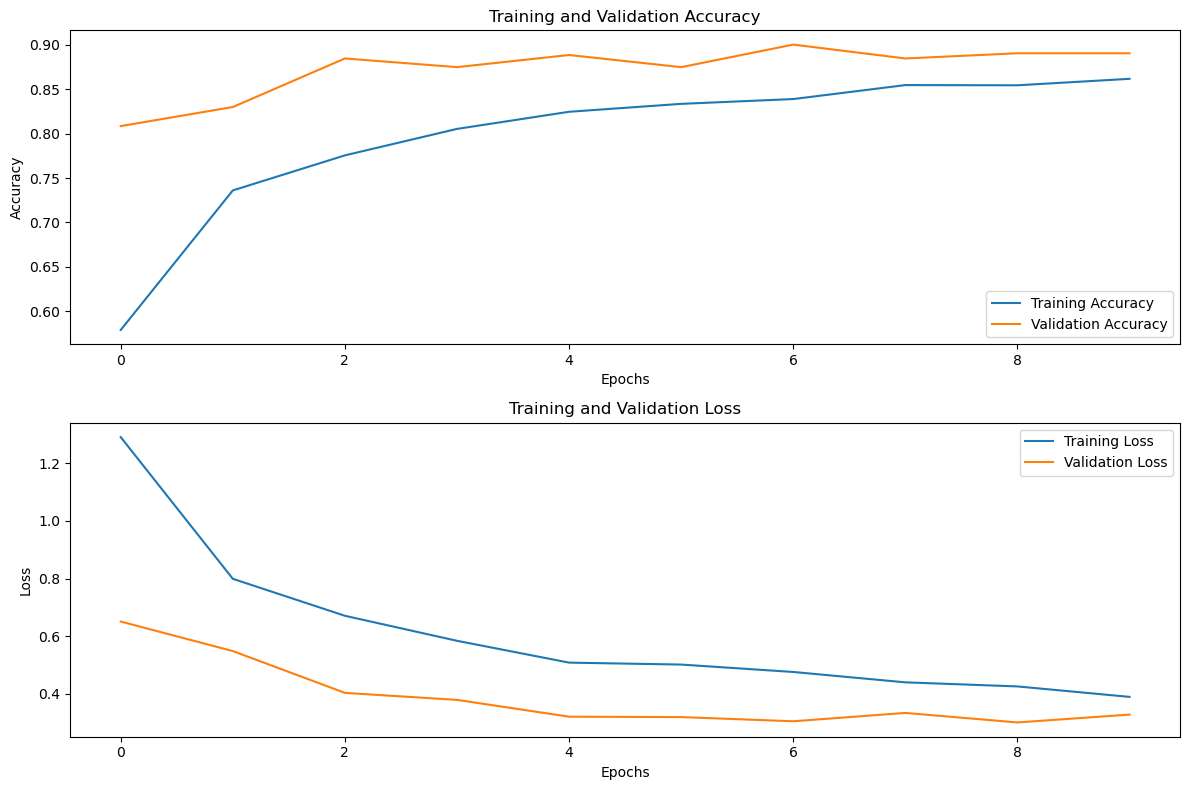

In [ ]:


# Extracting accuracy and loss from the history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Observations

## Model 5: Reset 50

The image size is set to 256x256 pixels, and the batch size for training is set to 32.

In [ ]:
# Set image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 32


batch_size = BATCH_SIZE
image_size = IMG_SIZE

A preprocessing function is defined to apply ResNet50-specific preprocessing.

In [ ]:
# Preprocessing function
def preprocess(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

Data augmentation techniques, such as random flipping and rotation, are applied to increase the diversity of the training data

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])


The function create_model constructs a model using transfer learning from a pre-trained ResNet50 model. The base model's layers are frozen, and new layers are added on top, including a global average pooling layer, a dense layer with dropout for regularization, and an output layer with 10 units for the 10 classes. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss.

In [ ]:
# Function to create the model
def create_model():
    base_model = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        layers.InputLayer(input_shape=IMG_SIZE + (3,)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Adjust output layer size
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Loading dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

# Split the dataset into train, validation, and test sets
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size - test_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Apply data augmentation only to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 16031 files belonging to 10 classes.


In [ ]:
train_dataset = train_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Create and train the model
model = create_model()

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)




Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1609s 4s/step - accuracy: 0.6639 - loss: 1.0064 - val_accuracy: 0.8869 - val_loss: 0.3455
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1803s 4s/step - accuracy: 0.8800 - loss: 0.3571 - val_accuracy: 0.8900 - val_loss: 0.3237
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1850s 5s/step - accuracy: 0.9032 - loss: 0.2843 - val_accuracy: 0.9050 - val_loss: 0.2618
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1841s 5s/step - accuracy: 0.9173 - loss: 0.2477 - val_accuracy: 0.9131 - val_loss: 0.2523
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1734s 4s/step - accuracy: 0.9269 - loss: 0.2148 - val_accuracy: 0.9069 - val_loss: 0.2674
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1771s 4s/step - accuracy: 0.9261 - loss: 0.2145 - val_accuracy: 0.9469 - val_loss: 0.1463
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1768s 4s/step - accuracy: 0.9346 - loss: 0.1862 - val_accuracy: 0.8969 - val_loss: 0.3129
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1808s 4s/step - accuracy: 0.9393 - loss: 0.1757 - 

In [ ]:
# Get the optimum number of epochs
optimum_epochs = len(history.history['val_accuracy']) - early_stopping.patience

# Print the optimum number of epochs
print("Optimum number of epochs:",optimum_epochs)

Optimum number of epochs: 14


The model is trained for 50 epochs with early stopping based on validation loss, restoring the best weights. The optimal number of epochs is determined to be 14, with the model reaching a validation accuracy of 0.9531 and a validation loss of 0.1264.

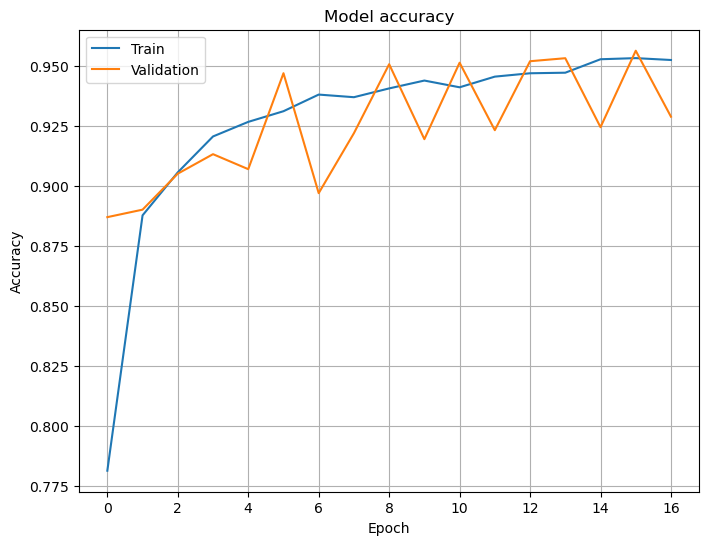

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

Both training and validation accuracy steadily increase over the epochs.
The training accuracy starts lower but quickly rises and stabilizes around 0.95.
The validation accuracy also follows a similar trend, showing fluctuations but stabilizing around 0.95,
indicating the model is learning effectively and generalizing well to validation data

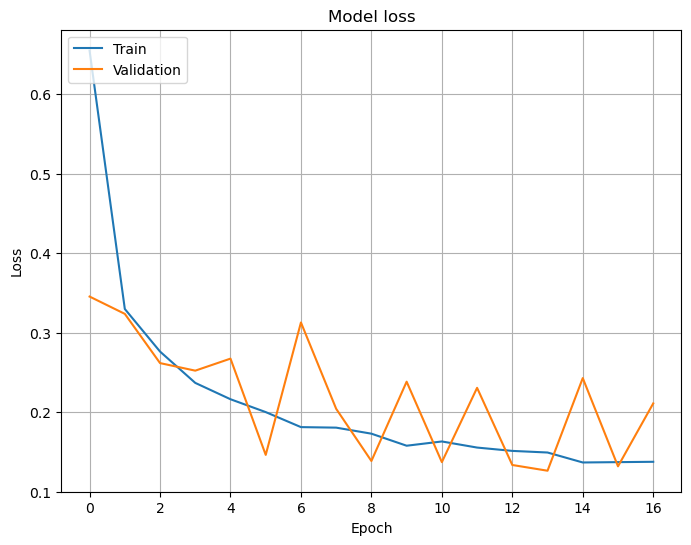

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


Both training and validation loss decrease significantly over the epochs.
The training loss starts high but drops rapidly, stabilizing around 0.1.
The validation loss also decreases, though it shows some fluctuations,
indicating variability in how well the model generalizes at different points.
However, it generally trends downwards, stabilizing around 0.2

**Graph Summary**

The graphs indicate that the model is effectively learning and
improving its performance on both the training and validation datasets over time.
The close alignment between training and validation accuracy and
the parallel decrease in loss for both datasets indicate that the model is generalizing well and not overfitting

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"test accuracy: {test_acc}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.9479 - loss: 0.1467
test accuracy: 0.9499683380126953


The model achieves a test accuracy of approximately 0.949, indicating good performance on unseen data.

In [ ]:
model.save('resnet50_model.keras')

In [ ]:
history.history

## Observations.

# 6. Model Tuning

In [ ]:

# Initialize a new W&B run
wandb.init(
    project='tomato_disease_detection',  # Replace with your project name
    config={
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'epochs': 50,
        'architecture': 'ResNet50',
        'dropout': 0.5,
        'dense_units': 256,
        'optimizer': 'Adam',
        'loss': 'sparse_categorical_crossentropy',
        'metrics': ['accuracy'],
        'learning_rate': 0.001,

    }
)



# Create and train the model
model = create_model()

# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with W&B callback
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, WandbCallback()]
)

# Finish the W&B run
wandb.finish()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
401/401 [==============================] - ETA: 0s - loss: 0.6627 - accuracy: 0.7816

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240727_095730-7ci5ojms/files/model-best)... Done. 0.3s


401/401 [==============================] - 392s 969ms/step - loss: 0.6627 - accuracy: 0.7816 - val_loss: 0.3963 - val_accuracy: 0.8625
Epoch 2/50
401/401 [==============================] - 382s 946ms/step - loss: 0.3378 - accuracy: 0.8857 - val_loss: 0.3994 - val_accuracy: 0.8625
Epoch 3/50
401/401 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.9098

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240727_095730-7ci5ojms/files/model-best)... Done. 0.3s


401/401 [==============================] - 394s 980ms/step - loss: 0.2647 - accuracy: 0.9098 - val_loss: 0.2361 - val_accuracy: 0.9169
Epoch 4/50
401/401 [==============================] - 380s 943ms/step - loss: 0.2264 - accuracy: 0.9207 - val_loss: 0.2734 - val_accuracy: 0.9075
Epoch 5/50
401/401 [==============================] - 382s 950ms/step - loss: 0.2284 - accuracy: 0.9198 - val_loss: 0.2555 - val_accuracy: 0.9175
Epoch 6/50
401/401 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9302

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240727_095730-7ci5ojms/files/model-best)... Done. 0.3s


401/401 [==============================] - 398s 990ms/step - loss: 0.2018 - accuracy: 0.9302 - val_loss: 0.2119 - val_accuracy: 0.9269
Epoch 7/50
401/401 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9376

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240727_095730-7ci5ojms/files/model-best)... Done. 0.3s


401/401 [==============================] - 401s 997ms/step - loss: 0.1804 - accuracy: 0.9376 - val_loss: 0.1749 - val_accuracy: 0.9400
Epoch 8/50
401/401 [==============================] - 381s 946ms/step - loss: 0.1792 - accuracy: 0.9392 - val_loss: 0.1931 - val_accuracy: 0.9319
Epoch 9/50
401/401 [==============================] - 380s 946ms/step - loss: 0.1751 - accuracy: 0.9384 - val_loss: 0.1758 - val_accuracy: 0.9362
Epoch 10/50
401/401 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9437

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240727_095730-7ci5ojms/files/model-best)... Done. 0.3s


401/401 [==============================] - 402s 1000ms/step - loss: 0.1651 - accuracy: 0.9437 - val_loss: 0.1490 - val_accuracy: 0.9444
Epoch 11/50
401/401 [==============================] - 383s 952ms/step - loss: 0.1547 - accuracy: 0.9425 - val_loss: 0.1992 - val_accuracy: 0.9344
Epoch 12/50
401/401 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9472

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240727_095730-7ci5ojms/files/model-best)... Done. 0.4s


401/401 [==============================] - 402s 1s/step - loss: 0.1549 - accuracy: 0.9472 - val_loss: 0.1465 - val_accuracy: 0.9506
Epoch 13/50
401/401 [==============================] - 382s 951ms/step - loss: 0.1573 - accuracy: 0.9467 - val_loss: 0.1998 - val_accuracy: 0.9319
Epoch 14/50
401/401 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9537

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240727_095730-7ci5ojms/files/model-best)... Done. 0.3s


401/401 [==============================] - 404s 1s/step - loss: 0.1342 - accuracy: 0.9537 - val_loss: 0.1197 - val_accuracy: 0.9556
Epoch 15/50
401/401 [==============================] - 386s 959ms/step - loss: 0.1457 - accuracy: 0.9530 - val_loss: 0.1681 - val_accuracy: 0.9444
Epoch 16/50
401/401 [==============================] - 384s 957ms/step - loss: 0.1437 - accuracy: 0.9491 - val_loss: 0.1336 - val_accuracy: 0.9563
Epoch 17/50
401/401 [==============================] - 388s 967ms/step - loss: 0.1386 - accuracy: 0.9523 - val_loss: 0.1835 - val_accuracy: 0.9381


accuracy,▁▅▆▇▇▇▇▇▇████████
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▅▄▅▆▇▆▇▇▆█▆█▇█▇
val_loss,██▄▅▄▃▂▃▂▂▃▂▃▁▂▁▃
accuracy,0.95231
best_epoch,13
best_val_loss,0.11975
epoch,16
loss,0.13858
val_accuracy,0.93813


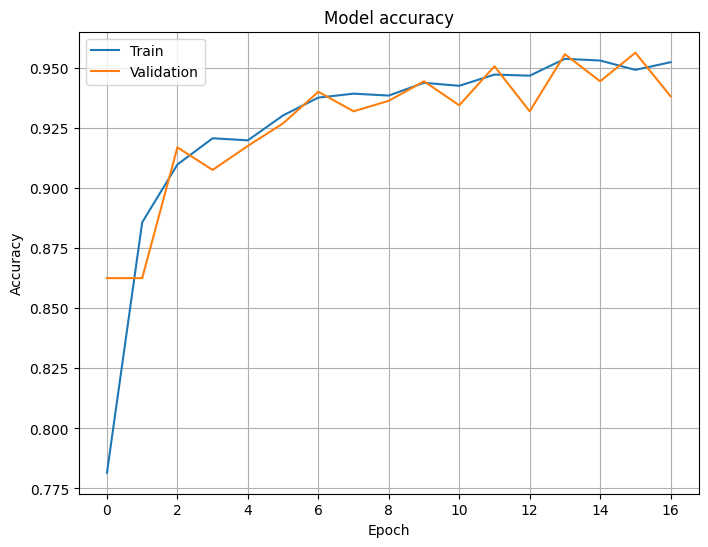

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"test accuracy: {test_acc}")

50/50 [==============================] - 62s 845ms/step - loss: 0.1458 - accuracy: 0.9543
test accuracy: 0.9543464779853821


In [ ]:
model.save('wandb.keras')